In [26]:
# Dependencies and Setup
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests
import datetime

# Import API key
from api_keys import API_KEY

# Incorporated citipy to determine city based on latitude and longitude
from citipy import citipy

# Output File (CSV)
output_data_file = "./output_data/cities.csv"

# Range of latitudes and longitudes
lat_range = (-90, 90)
lng_range = (-180, 180)

In [27]:
# List for holding lat_lngs and cities
lat_lngs = []
cities = []
country_codes = []

# Create a set of random lat and lng combinations
lats = np.random.uniform(low=-90.000, high=90.000, size=1500)
lngs = np.random.uniform(low=-180.000, high=180.000, size=1500)
lat_lngs = zip(lats, lngs)

# Identify nearest city for each lat, lng combination
for lat_lng in lat_lngs:
    city = citipy.nearest_city(lat_lng[0], lat_lng[1])
    city_name = city.city_name
    country_code = city.country_code
    
    # If the city is unique, then add it to a our cities list & also add its corresponding country code
    if city_name not in cities:
        cities.append(city_name)
        country_codes.append(country_code)

# Print the city count to confirm sufficient count
print('The above script has generated {} different cities using random numbers.'.format(len(set(cities))))

The above script has generated 648 different cities using random numbers.


In [28]:
#create a dataframe to store all the cities and countries generated with citipy
df_countries = pd.DataFrame({'City': cities, 'Country': country_codes})

#add additional blank columns to store information from openweathermap api
df_countries['Latitude'] = ''
df_countries['Longitude'] = ''
df_countries['Max Temperature (F)'] = ''
df_countries['Humidity (%)'] = ''
df_countries['Cloudiness (%)'] = ''
df_countries['Wind Speed (mph)'] = ''
df_countries['Date'] = ''

# keeps count of those cities whose weather information is successfully obtained
city_count = 0

# initializing # of variables
api_call_count = 1 # count for API calls made to OpenWeatherAPI, max 60 counts allowed for free API calls
sets = 0 # counter to count the number of call sets
t0 = time.time() # get current time

#loop through all rows and fill in values for blank columns in dataframe
for index,row in df_countries.iterrows():
    city_name = row['City']
    country_id = row['Country']
    
    # create a dictionary to contain the query parameters
    search_parameters = {
        "q": str(city_name)+","+str(country_id),
        "units": "IMPERIAL",
        "mode": "json",
        "APPID": API_KEY
    }
    
    #api call for all Cities 
    target_url = "http://api.openweathermap.org/data/2.5/weather"
    country_info = requests.get(target_url, params = search_parameters).json()
    
    try:
        df_countries.loc[index,'Latitude'] = country_info['coord']['lat']
        df_countries.loc[index,'Longitude'] = country_info['coord']['lon']
        df_countries.loc[index,'Max Temperature (F)'] = country_info['main']['temp_max']
        df_countries.loc[index,'Humidity (%)'] = country_info['main']['humidity']
        df_countries.loc[index,'Cloudiness (%)'] = country_info['clouds']['all']
        df_countries.loc[index,'Wind Speed (mph)'] = country_info['wind']['speed']
        df_countries.loc[index, 'Date'] = country_info['dt']
        
        #print log for each city
        print(f'Processing Record {api_call_count} of Set {sets} | {city_name}' )
        
        city_count = city_count + 1 # only increment if you get all the weather information
    
    except KeyError:
        df_countries.loc[index,'Latitude'] = np.nan
        df_countries.loc[index,'Longitude'] = np.nan
        df_countries.loc[index,'Max Temperature (F)'] = np.nan
        df_countries.loc[index,'Humidity (%)'] = np.nan
        df_countries.loc[index,'Cloudiness (%)'] = np.nan
        df_countries.loc[index,'Wind Speed (mph)'] = np.nan
        df_countries.loc[index,'Date'] = np.nan
        print(f"Missing weather information for city named: {city_name} ...hence skipping")
    api_call_count = api_call_count + 1        
    if api_call_count == 51: # loop to limit 50 API calls per minute. The OpenWeatherMap API limit is 60 calls/min
        t1 = time.time()
        api_call_count = 1 # reset it for next 50 calls
        sets = sets+1
        time.sleep(60-(t1-t0))
        t0 = time.time()
print(f"Processing successfully completed. Retrieved weather information for {city_count} cities")


Processing Record 1 of Set 0 | ferme-neuve
Processing Record 2 of Set 0 | punta arenas
Processing Record 3 of Set 0 | cabatuan
Processing Record 4 of Set 0 | albany
Processing Record 5 of Set 0 | ushuaia
Processing Record 6 of Set 0 | rikitea
Missing weather information for city named: mataura ...hence skipping
Processing Record 8 of Set 0 | nara
Processing Record 9 of Set 0 | kaitangata
Processing Record 10 of Set 0 | anloga
Processing Record 11 of Set 0 | eyl
Processing Record 12 of Set 0 | konskie
Processing Record 13 of Set 0 | santa maria da vitoria
Processing Record 14 of Set 0 | hermanus
Processing Record 15 of Set 0 | tasiilaq
Processing Record 16 of Set 0 | new norfolk
Processing Record 17 of Set 0 | constitucion
Processing Record 18 of Set 0 | castro
Processing Record 19 of Set 0 | igarka
Processing Record 20 of Set 0 | chicama
Missing weather information for city named: marcona ...hence skipping
Processing Record 22 of Set 0 | meulaboh
Processing Record 23 of Set 0 | baruun-

In [29]:
#change all data recieved from openweathermap api to numerical data
df_countries['Latitude'] = pd.to_numeric(df_countries['Latitude'])
df_countries['Longitude'] = pd.to_numeric(df_countries['Longitude'])
df_countries['Max Temperature (F)'] = pd.to_numeric(df_countries['Max Temperature (F)'])
df_countries['Humidity (%)'] = pd.to_numeric(df_countries['Humidity (%)'])
df_countries['Cloudiness (%)'] = pd.to_numeric(df_countries['Cloudiness (%)'])
df_countries['Wind Speed (mph)'] = pd.to_numeric(df_countries['Wind Speed (mph)'])

#display dataframe df_countries after openweathermap api calls removing those with NaNs elements
df_countries = df_countries.dropna()

# Reorder columns as we're interested in for the final DataFrame
df_countries = df_countries[["City", "Cloudiness (%)", "Country", "Date", "Humidity (%)","Latitude","Longitude",
                       "Max Temperature (F)", "Wind Speed (mph)"]]

print(df_countries.count()) # displays the count of rows
print(df_countries.head(20)) # displays first 20 records
df_countries.dtypes # displays the Dataype of dataframe
df_countries.to_csv(output_data_file, encoding="utf-8", index=False)

City                   563
Cloudiness (%)         563
Country                563
Date                   563
Humidity (%)           563
Latitude               563
Longitude              563
Max Temperature (F)    563
Wind Speed (mph)       563
dtype: int64
                      City  Cloudiness (%) Country        Date  Humidity (%)  \
0              ferme-neuve            68.0      ca  1546893493          54.0   
1             punta arenas             0.0      cl  1546891200          58.0   
2                 cabatuan            88.0      ph  1546893493          92.0   
3                   albany            90.0      au  1546891200          72.0   
4                  ushuaia            75.0      ar  1546891200          61.0   
5                  rikitea            80.0      pf  1546893494          96.0   
7                     nara            92.0      ml  1546893494          28.0   
8               kaitangata            12.0      nz  1546893494          63.0   
9                   anlo

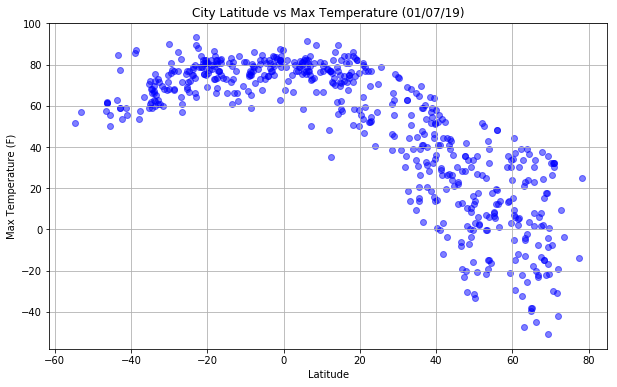

In [33]:
# Plotting the Data - Latitude vs. Temperature Plot
plt.figure(figsize=(10,6))
plt.scatter(df_countries["Latitude"], df_countries["Max Temperature (F)"], color='b', alpha=0.5)
plt.grid()
plt.xlabel('Latitude')
plt.ylabel('Max Temperature (F)')
plt.title(f'City Latitude vs Max Temperature ({datetime.datetime.now().strftime("%D")})')
plt.savefig("./output_data/LatVsMaxTemp.png")
plt.show()

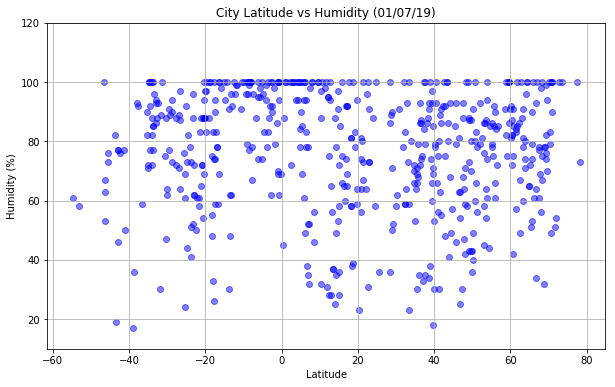

In [34]:
# Plotting the Data - Latitude vs. Humidity Plot
plt.figure(figsize=(10,6))
plt.scatter(df_countries["Latitude"], df_countries["Humidity (%)"], color='blue', alpha=0.5)
plt.ylim(10,120)
plt.grid()
plt.xlabel('Latitude')
plt.ylabel('Humidity (%)')
plt.title(f'City Latitude vs Humidity ({datetime.datetime.now().strftime("%D")})')
plt.savefig("./output_data/LatVsHumidity.png")
plt.show()

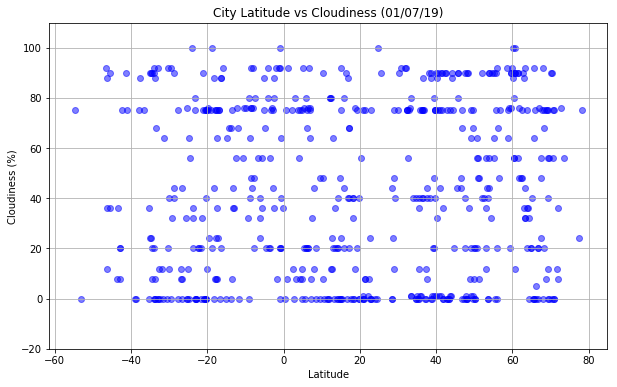

In [35]:
# Plotting the Data - Latitude vs. Cloudiness Plot
plt.figure(figsize=(10,6))
plt.scatter(df_countries["Latitude"], df_countries["Cloudiness (%)"], color='b', alpha=0.5)
plt.grid()
plt.ylim(-20,(df_countries["Cloudiness (%)"].max()+10))
plt.xlabel('Latitude')
plt.ylabel('Cloudiness (%)')
plt.title(f'City Latitude vs Cloudiness ({datetime.datetime.now().strftime("%D")})')
plt.savefig("./output_data/LatVsCloudiness.png")
plt.show()

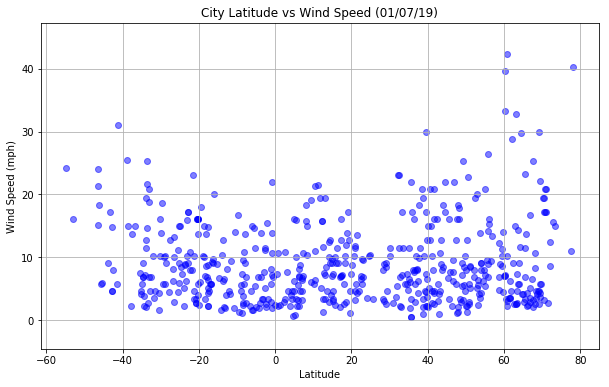

In [36]:
# Plotting the Data - Latitude vs. Wind Speed Plot
plt.figure(figsize=(10,6))
plt.scatter(df_countries["Latitude"], df_countries["Wind Speed (mph)"], color='blue', alpha=0.5)
plt.grid()
plt.ylim((df_countries["Wind Speed (mph)"].min()-5),(df_countries["Wind Speed (mph)"].max()+5))
plt.xlabel('Latitude')
plt.ylabel('Wind Speed (mph)')
plt.title(f'City Latitude vs Wind Speed ({datetime.datetime.now().strftime("%D")})')
plt.savefig("./output_data/LatVsWind.png")
plt.show()